<a href="https://colab.research.google.com/github/Shashwat-Manglam-Jain/brain-tumor-mri-prediction/blob/main/brain_tumor_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shashwatmanglamjain","key":"f7519b3852293a3287331245d9359534"}'}

In [ ]:
import os

# Create a directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 85% 127M/149M [00:00<00:00, 287MB/s] 
100% 149M/149M [00:00<00:00, 304MB/s]


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 92.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
train_path = "/content/Training"
test_path = "/content/Testing"

# Function to count images in each category
def count_images(dataset_path):
    print(f"Dataset Path: {dataset_path}")
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):  # Ensure it's a folder
            print(f"{category}: {len(os.listdir(category_path))} images")

# Count images in Training dataset
print("\n📌 Training Set:")
count_images(train_path)

# Count images in Testing dataset
print("\n📌 Testing Set:")
count_images(test_path)



📌 Training Set:
Dataset Path: /content/Training
pituitary: 1457 images
notumor: 1595 images
meningioma: 1339 images
glioma: 1321 images

📌 Testing Set:
Dataset Path: /content/Testing
pituitary: 300 images
notumor: 405 images
meningioma: 306 images
glioma: 300 images


##Visualize Sample Images

Categories found: ['pituitary', 'notumor', 'meningioma', 'glioma']


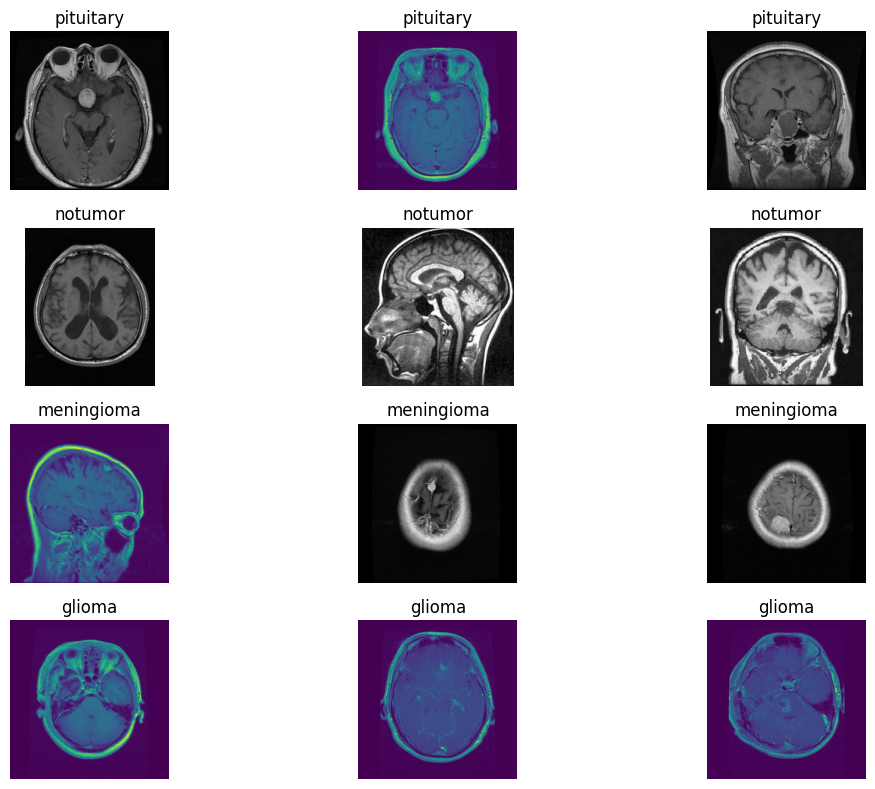

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset path
train_path = "/content/Training"

# List available categories (folders)
categories = os.listdir(train_path)
print("Categories found:", categories)

# Set the number of images to display per category
num_images_per_category = 3

# Create a figure for displaying images
plt.figure(figsize=(12, 8))

# Loop through each category and display images
for category_idx, category in enumerate(categories):
    category_path = os.path.join(train_path, category)

    # Check if category folder exists
    if not os.path.isdir(category_path):
        print(f"Skipping '{category}' as it is not a folder.")
        continue

    # Get sample images from the category folder
    sample_images = os.listdir(category_path)[:num_images_per_category]

    # Display images
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(category_path, img_name)

        try:
            img = Image.open(img_path)  # Load image using PIL

            # Create subplot: Rows = number of categories, Columns = num_images_per_category
            plt.subplot(len(categories), num_images_per_category, category_idx * num_images_per_category + i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(category)

        except Exception as e:
            print(f"Warning: Could not load {img_name} from {category} - {e}")

# Show all images
plt.tight_layout()
plt.show()


##ImageDataGenerator for Data Augmentatiaon

In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation only for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescale for validation (NO augmentation for validation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load Train Data
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load Validation (Test) Data
val_data = val_datagen.flow_from_directory(
    test_path,  # ✅ Load test images without splitting again
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


##Define CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Binary Classification Output
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##Compile the Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


##Train Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 81/179 ━━━━━━━━━━━━━━━━━━━━ 45s 461ms/step - accuracy: 0.2434 - loss: -192.6830

KeyboardInterrupt: 

##Accuracy

In [ ]:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy*100:.2f}%")


## Visualize Training Progress

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()


##Make Predictions on New Images

In [ ]:
import cv2
import numpy as np

# Load an image for prediction
img_path = "/path/to/test/image.jpg"  # Update this
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))  # Resize to model input shape
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
prediction = model.predict(img)
if prediction[0][0] > 0.5:
    print("Tumor Detected")
else:
    print("No Tumor Detected")


##Use a Pretrained Model (ResNet, VGG, etc.*)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


#Load Pretrained Model (ResNet50)

In [ ]:
# Load Pretrained ResNet50 Model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of ResNet50 so they don't get trained initially
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Add Custom Layers for Brain Tumor Classificatio

In [ ]:
# Add custom classification layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)  # 4 categories: Meningioma, Glioma, Pituitary, No Tumor

# Create the final model
model = Model(inputs=base_model.input, outputs=x)


#Compile the Model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Load Your Dataset (MRI Brain Tumors)



In [ ]:
train_path = "/content/Training"
test_path = "/content/Testing"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation and Normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% Train, 20% Validation
)

# Load Training & Validation Data
train_data = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Because we have 4 classes
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_path,  # Validation data also from Training folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


#Train the Model

In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=10,  # You can increase epochs
                    steps_per_epoch=len(train_data),
                    validation_steps=len(val_data))


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 585ms/step - accuracy: 0.4051 - loss: 1.2908 - val_accuracy: 0.4908 - val_loss: 1.1900
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.4841 - loss: 1.0757 - val_accuracy: 0.4303 - val_loss: 1.2107
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 501ms/step - accuracy: 0.4871 - loss: 1.0671 - val_accuracy: 0.4040 - val_loss: 1.2098
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 499ms/step - accuracy: 0.5120 - loss: 1.0343 - val_accuracy: 0.4715 - val_loss: 1.1739
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 494ms/step - accuracy: 0.5193 - loss: 1.0333 - val_accuracy: 0.4908 - val_loss: 1.1873
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 498ms/step - accuracy: 0.5413 - loss: 0.9940 - val_accuracy: 0.4777 - val_loss: 1.1540
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 549ms/step - accuracy: 0.5502 - loss: 1.0056 - val_accuracy: 0.4785 - val_loss: 1.1821
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 499ms/step - accuracy: 0.5185 - loss: 

**Save** the Model for Future Use

In [ ]:
model.save("brain_tumor_resnet50.h5")
print("Model saved successfully!")


Model saved successfully!


#Load & Use the Saved Model for Predictions

In [ ]:
# Load saved model
loaded_model = tf.keras.models.load_model("brain_tumor_resnet50.h5")

# Make a prediction on a single image
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/Testing/meningioma/Te-me_0188.jpg"  # Change to an actual image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Predict
prediction = loaded_model.predict(img_array)
class_names = ['Meningioma', 'No Tumor', 'Glioma', 'Pituitary']
predicted_class = class_names[np.argmax(prediction)]
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Meningioma


In [ ]:
# Import Required Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define Paths
train_path = "/content/Training"
test_path = "/content/Testing"

# Set Parameters
IMG_SIZE = (224, 224)  # Image size for resizing
BATCH_SIZE = 32  # Batch size

# ✅ Data Augmentation (Stronger Augmentations to Prevent Overfitting)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # More rotation
    width_shift_range=0.3,  # More shifts
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,  # More zoom
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 80% Train, 20% Validation
)

# ✅ Load Train & Validation Data
train_data = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# ✅ Define CNN Model with Dropout & Regularization
model = Sequential([
    # 1st Convolutional Layer
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),  # Dropout to prevent overfitting

    # 2nd Convolutional Layer
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # 3rd Convolutional Layer
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # More dropout for fully connected layers
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# ✅ Compile Model with Lower Learning Rate
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# ✅ Early Stopping (Stop Training If Validation Loss Increases)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train Model
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stop])

# ✅ Plot Training & Validation Accuracy/Loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# ✅ Show Results
plot_history(history)


In [ ]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50  # Pretrained model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define Paths
train_path = "/content/Training"
test_path = "/content/Testing"

# Set Parameters
IMG_SIZE = (224, 224)  # Image size
BATCH_SIZE = 32  # Batch size

# ✅ Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% Train, 20% Validation
)

# ✅ Load Train & Validation Data
train_data = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# ✅ Load Pretrained ResNet50 (Feature Extractor)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the Pretrained Model
base_model.trainable = False  # This prevents training the ResNet layers

# ✅ Define the Transfer Learning Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces dimensionality
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Output Layer (binary classification)
])

# ✅ Compile Model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# ✅ Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train Model
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stop])

# ✅ Plot Accuracy & Loss
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

plot_history(history)
